In [52]:
import yfinance as yf
import pandas as pd

In [34]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

In [35]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-04 00:00:00-05:00,5998.140137,6042.479980,5990.870117,6037.879883,4410160000,0.0,0.0
2025-02-05 00:00:00-05:00,6020.450195,6062.859863,6007.060059,6061.479980,4756250000,0.0,0.0
2025-02-06 00:00:00-05:00,6072.220215,6084.029785,6046.830078,6083.569824,4847120000,0.0,0.0


In [38]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [40]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [42]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [44]:
sp500 = sp500.loc["1990-01-01":].copy()

In [46]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2025-02-04 00:00:00-05:00,5998.140137,6042.479980,5990.870117,6037.879883,4410160000,6061.479980,1
2025-02-05 00:00:00-05:00,6020.450195,6062.859863,6007.060059,6061.479980,4756250000,6083.569824,1
2025-02-06 00:00:00-05:00,6072.220215,6084.029785,6046.830078,6083.569824,4847120000,6025.990234,0


In [54]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [56]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds =  pd.Series(preds, index=test.index)

precision_score(test["Target"], preds)

0.5384615384615384

<Axes: xlabel='Date'>

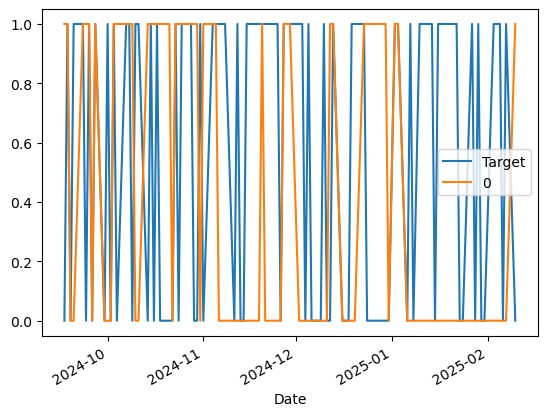

In [58]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [60]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [64]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [66]:
predictions = backtest(sp500, model, predictors)

In [68]:
predictions["Predictions"].value_counts()

Predictions
0    3701
1    2642
Name: count, dtype: int64

In [70]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5287660862982589

In [72]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536182
0    0.463818
Name: count, dtype: float64

In [74]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

In [76]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [78]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio2,Trend_2,Close_Ratio5,Trend_5,Close_Ratio60,Trend_60,Close_Ratio250,Trend_250,Close_Ratio1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 00:00:00-05:00,5998.140137,6042.479980,5990.870117,6037.879883,4410160000,6061.479980,1,1.003599,1.0,1.000197,2.0,1.008482,35.0,1.090787,143.0,1.320308,527.0
2025-02-05 00:00:00-05:00,6020.450195,6062.859863,6007.060059,6061.479980,4756250000,6083.569824,1,1.001951,2.0,1.003369,3.0,1.012051,35.0,1.094175,143.0,1.324847,527.0
2025-02-06 00:00:00-05:00,6072.220215,6084.029785,6046.830078,6083.569824,4847120000,6025.990234,0,1.001819,2.0,1.006613,3.0,1.015427,35.0,1.097300,143.0,1.329051,527.0


In [80]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [82]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [84]:
predictions = backtest(sp500, model, new_predictors)

In [86]:
predictions["Predictions"].value_counts()

Predictions
0.0    4482
1.0     861
Name: count, dtype: int64

In [88]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5749128919860628

In [90]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2025-02-04 00:00:00-05:00,1,0.0
2025-02-05 00:00:00-05:00,1,1.0
2025-02-06 00:00:00-05:00,0,1.0
